In [104]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
# network configuration
N = [100, 50]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, p]  + [0] * len(N)

# prob. of failure at inference
# @see ComparisonIncreasingDropoutMNIST.ipynb
p_inference = get_p_arr(0.05)

# prob. of failure at train
# @see ComparisonIncreasingDropoutMNIST.ipynb
p_train = get_p_arr(0)#get_p_arr(0.02)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# @see ComparisonIncreasingDropoutMNIST.ipynb
repetitions = 6

# number of runs for each regularization coefficient
runs = 5

# using v3 because v4 is too slow (16 seconds vs 30 seconds)
reg_bound = 'v3'
reg_bound_coeffs = np.logspace(-5, 2, 5)

In [107]:
def get_results(reg_bound_coeff):
    # obtaining the distribution after 10 epochs
    results = []
    
    def unravel(name, data):
        return {name + '_' + key: data[key] for key in data.keys()}
    
    for _ in tqdm(range(runs)):
        exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = p_train, KLips = KLips, epochs = 10,
                                      activation = activation, do_print = None,
                                      name = 'experiment_regularization', seed = None, batch_size = 100,
                                      reg_type = 'vardelta', reg_coeff = {'lambda': reg_bound_coeff,
                                                                          'p': np.max(p_inference)})
        
        results += [{**unravel('correct_acc', exp.get_accuracy_correct(test_only = True)), # test_only = True
                     **unravel('crashing_acc', exp.get_accuracy_crash(test_only = True, repetitions = repetitions)), # test_only = True
                     
                     **unravel('correct_mae', exp.get_mae_correct()),
                     **unravel('crashing_mae', exp.get_mae_crash(repetitions = repetitions)),
                     
                     'v2_var': np.mean(exp.get_bound_v2(exp.x_train)['std'] ** 2),
                     'v2_mean': np.mean(exp.get_bound_v2(exp.x_train)['mean']),
                     
                     'v3_var': np.mean(exp.get_bound_v3(exp.x_train)['std'] ** 2),
                     'v3_mean': np.mean(exp.get_bound_v3(exp.x_train)['mean']),
                               
                     #'v4_var': np.mean(exp.get_bound_v4(exp.x_train)['std'] ** 2),
                     #'v4_mean': np.mean(exp.get_bound_v4(exp.x_train)['mean']),
                     
                     'v1_infnorm_mean': np.mean(exp.get_bound_v1_infnorm(exp.x_train)['mean']),
                    }]
        
        # freeing up the memory
        tf.reset_default_graph()
        K.clear_session()
        
    # list of all keys
    keys = list(results[0].keys())
    
    # return results
    return {key: [value[key] for value in results] for key in keys}

def process_results_single(results):
    for key, value in results.items():
        plt.figure()
        plt.title('%s: %.3f +- %.3f med %.3f' % (key, np.mean(value), np.std(value), np.median(value)))
        plt.hist(value)
        plt.xlabel(key)
        plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

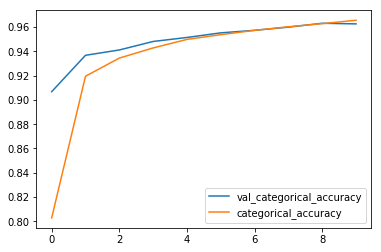

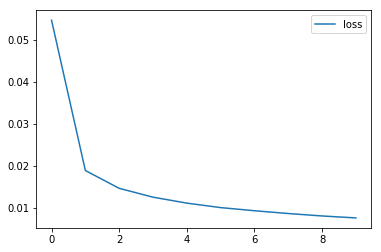

 20%|██        | 1/5 [01:08<04:34, 68.66s/it]

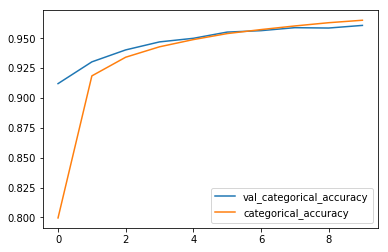

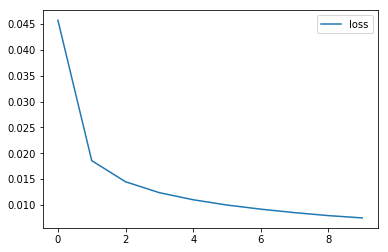

 40%|████      | 2/5 [02:17<03:26, 68.79s/it]

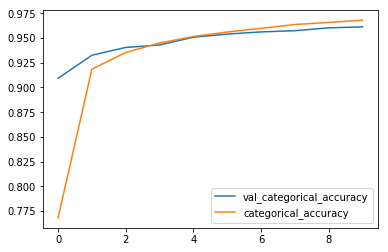

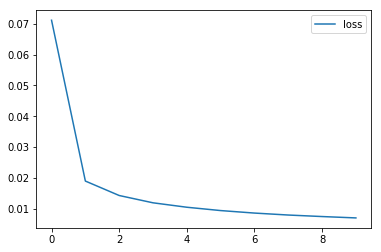

 60%|██████    | 3/5 [03:26<02:17, 68.76s/it]

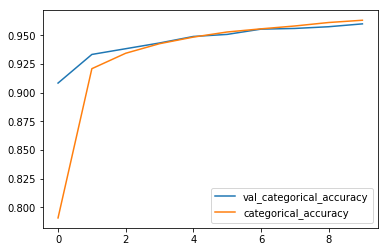

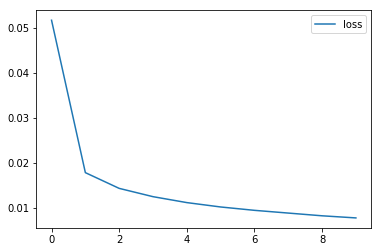

 80%|████████  | 4/5 [04:36<01:09, 69.10s/it]

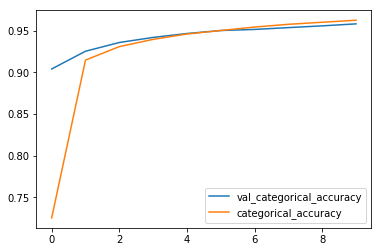

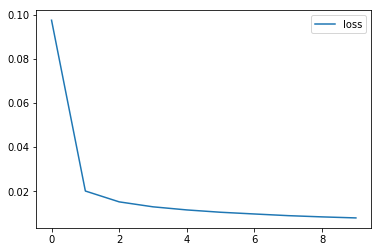

  0%|          | 0/5 [00:00<?, ?it/s]

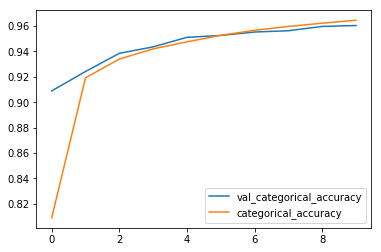

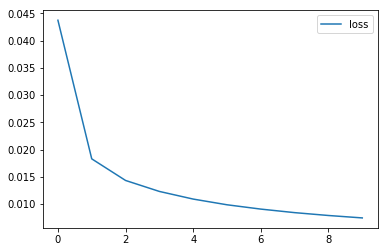

 20%|██        | 1/5 [01:08<04:35, 68.97s/it]

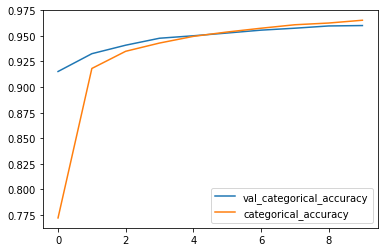

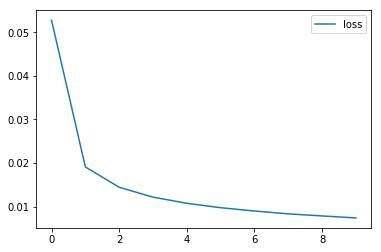

 40%|████      | 2/5 [02:17<03:26, 68.87s/it]

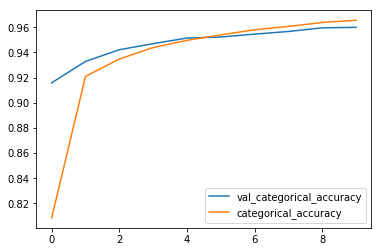

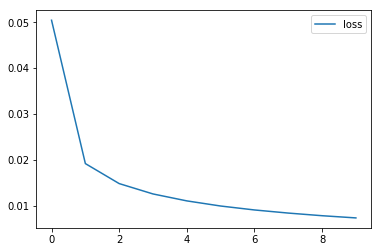

 60%|██████    | 3/5 [03:27<02:18, 69.09s/it]

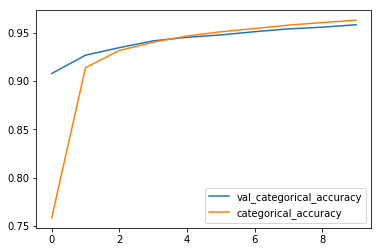

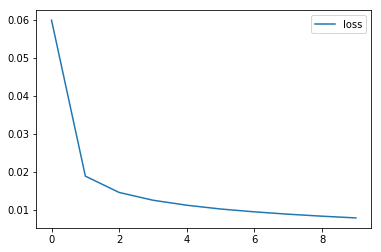

 80%|████████  | 4/5 [04:36<01:09, 69.17s/it]

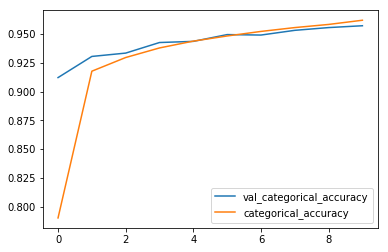

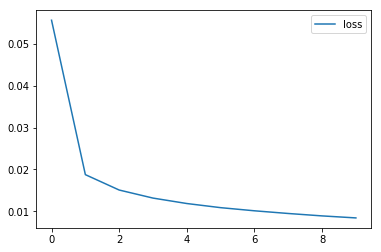

  0%|          | 0/5 [00:00<?, ?it/s]

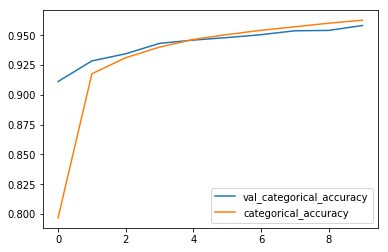

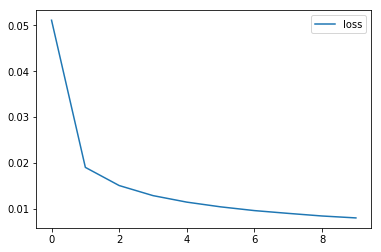

 20%|██        | 1/5 [01:03<04:13, 63.46s/it]

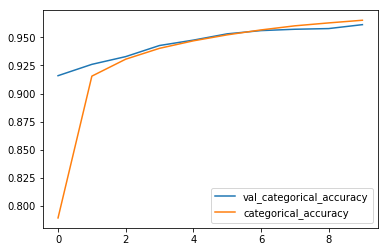

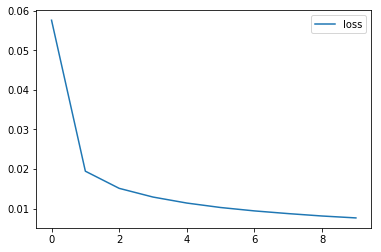

 40%|████      | 2/5 [02:13<03:16, 65.34s/it]

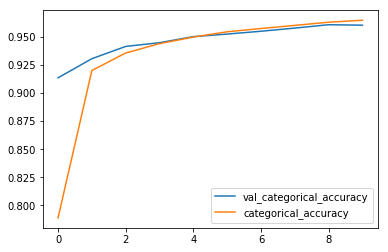

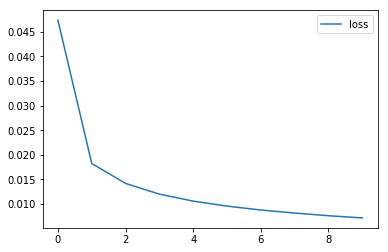

 60%|██████    | 3/5 [03:23<02:13, 66.69s/it]

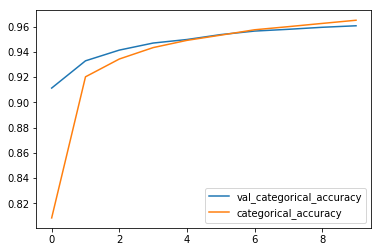

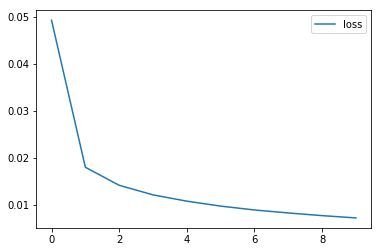

 80%|████████  | 4/5 [04:32<01:07, 67.55s/it]

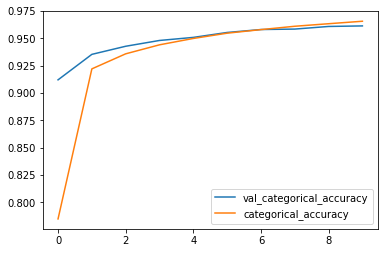

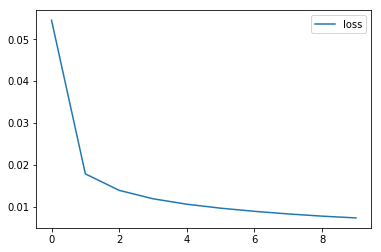

  0%|          | 0/5 [00:00<?, ?it/s]

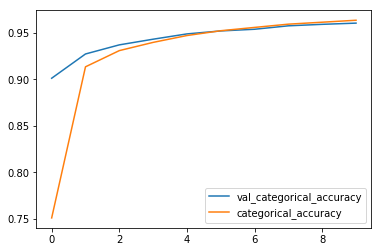

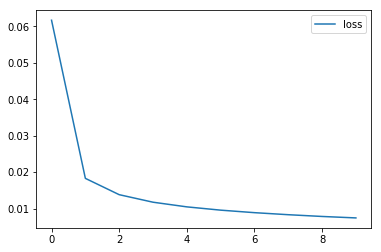

 20%|██        | 1/5 [01:09<04:39, 69.79s/it]

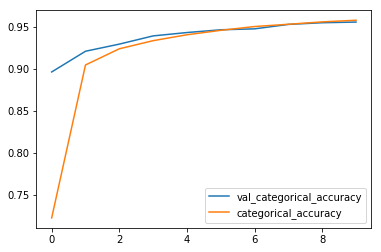

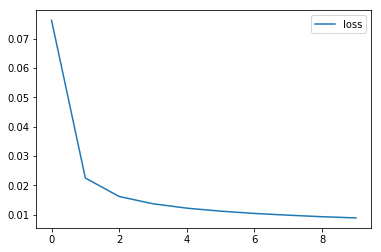

 40%|████      | 2/5 [02:18<03:28, 69.47s/it]

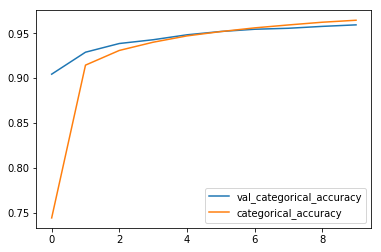

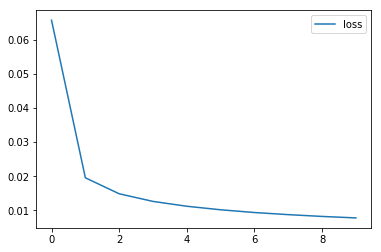

 60%|██████    | 3/5 [03:28<02:18, 69.48s/it]

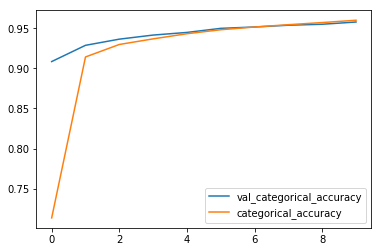

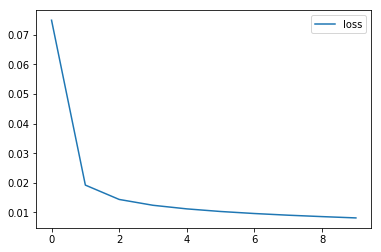

 80%|████████  | 4/5 [04:38<01:09, 69.83s/it]

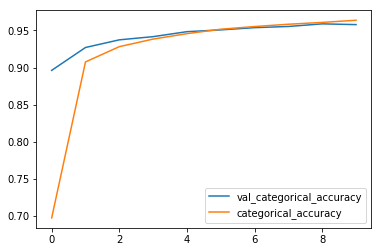

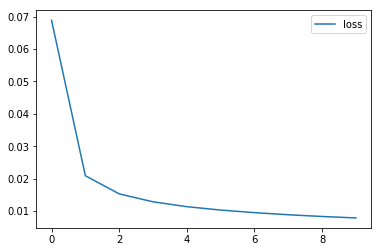

  0%|          | 0/5 [00:00<?, ?it/s]

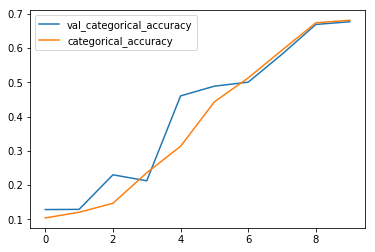

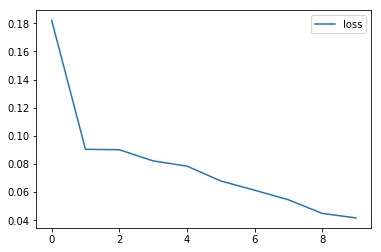

 20%|██        | 1/5 [01:09<04:39, 69.83s/it]

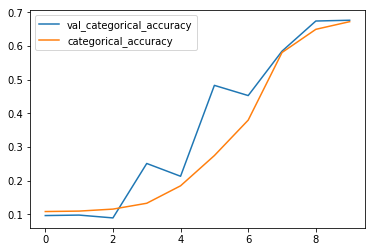

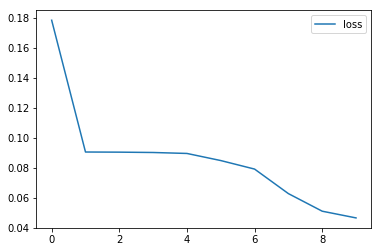

 40%|████      | 2/5 [01:50<03:02, 60.99s/it]

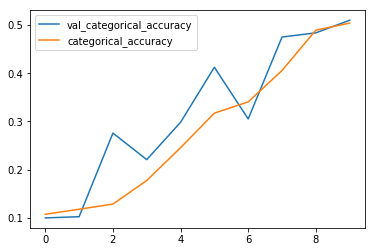

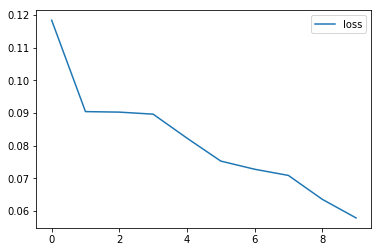

 60%|██████    | 3/5 [02:23<01:45, 52.72s/it]

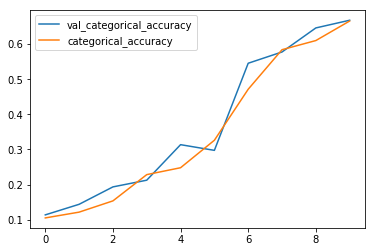

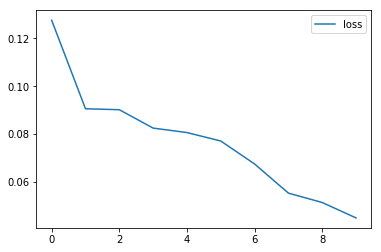

 80%|████████  | 4/5 [02:56<00:46, 46.88s/it]

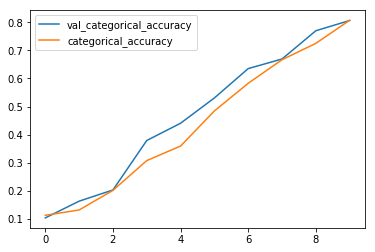

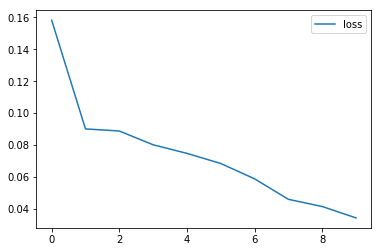

100%|██████████| 5/5 [03:29<00:00, 42.72s/it]


In [5]:
# obtaining results
results_array = [get_results(reg_bound_coeff) for reg_bound_coeff in reg_bound_coeffs]

In [5]:
save_fn = 'Regularization.ipynb.coarse.pkl'
#pickle.dump(results_array, open(save_fn, 'wb'))
results_array = pickle.load(open(save_fn, 'rb'))

Dropout baseline
![ACC dropout](figures/comparison_acc_do_mnist.png) ![MAE Dropout](figures/comparison_mae_do_mnist.png)

In [6]:
def plot_quantity(results_array, name, axis = plt, style = '-', **kwargs):
    """ Plot mean and variance of a quantity in results_array with name """
    means = np.array([np.mean(r[name]) for r in results_array])
    stds  = [np.std(r[name]) for r in results_array]
    if name.startswith('v'):
        name = 'b' + name[1:]
    axis.plot(reg_bound_coeffs, means, style, label = name, **kwargs)
    axis.fill_between(reg_bound_coeffs, means - stds, means + stds, alpha = 0.5, **kwargs)
    plt.xscale('log')

In [13]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

<Figure size 432x288 with 0 Axes>

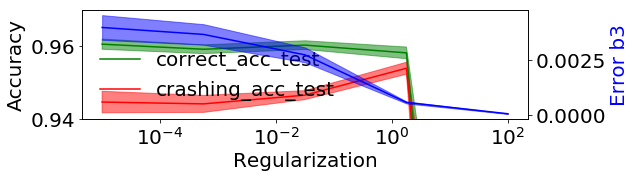

In [19]:
# it also behaves the same for train
plt.figure()

fig, ax1 = plt.subplots(figsize=(8, 2))

#plt.title('Accuracy over the dataset and train dropout')
plot_quantity(results_array, 'correct_acc_test', color = 'green', axis = ax1)
plot_quantity(results_array, 'crashing_acc_test', color = 'red', axis = ax1)
#plot_quantity(results_array, 'correct_acc_train', color = 'green', style = '--',  axis = ax1)
#plot_quantity(results_array, 'crashing_acc_train', color = 'red', style = '--', axis = ax1)

ax2 = ax1.twinx()
#ax3 = ax1.twinx()
#ax4 = ax1.twinx()
ax2.set_ylabel('Error b3', color = 'blue')
plot_quantity(results_array, 'v3_var', color = 'blue', axis = ax2)
#plot_quantity(results_array, 'v4_var', axis = ax2)
ax1.set_xlabel('Regularization')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.94, 0.97)
#ax1.set_xscale('log')
ax1.legend(loc = 3, framealpha = 0)
#ax2.legend()
plt.savefig('figures/comparison_acc_do_reg_mnist.pdf', bbox_inches = 'tight')
#plt.savefig('figures/comparison_acc_do_mnist.png', bbox_inches = 'tight')
plt.show()

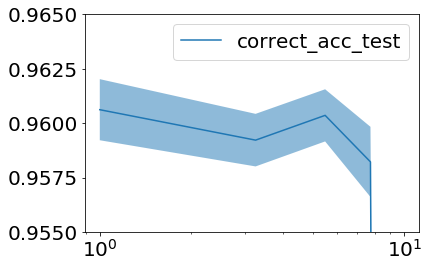

In [52]:
plt.figure()
plot_quantity(results_array, 'correct_acc_test')
plt.ylim(0.955, 0.965)
plt.legend()
plt.show()

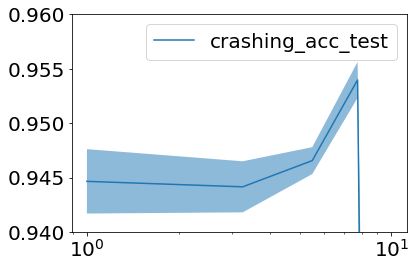

In [53]:
plt.figure()
plot_quantity(results_array, 'crashing_acc_test')
plt.ylim(0.94, 0.96)
plt.legend()
plt.show()

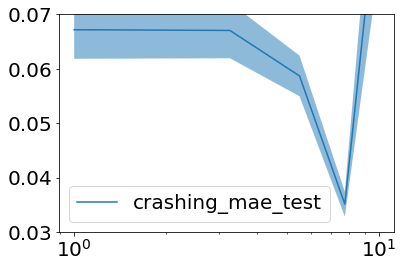

In [54]:
plt.figure()
plot_quantity(results_array, 'crashing_mae_test')
plt.ylim(0.03, 0.07)
plt.legend()
plt.show()

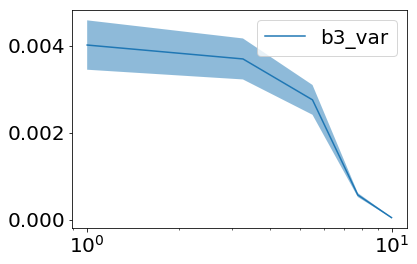

In [55]:
plt.figure()
plot_quantity(results_array, 'v3_var')
plt.legend()
plt.show()

In [56]:
# fine set of points
reg_bound_coeffs = np.linspace(1, 10, 5)

In [12]:
# obtaining results
results_array = [get_results(reg_bound_coeff) for reg_bound_coeff in reg_bound_coeffs]

100%|██████████| 5/5 [05:51<00:00, 70.30s/it]


In [13]:
save_fn = 'Regularization.ipynb.fine.pkl'
#pickle.dump(results_array, open(save_fn, 'wb'))
results_array = pickle.load(open(save_fn, 'rb'))

In [14]:
def plot_quantity(results_array, name):
    """ Plot mean and variance of a quantity in results_array with name """
    means = np.array([np.mean(r[name]) for r in results_array])
    stds  = [np.std(r[name]) for r in results_array]
    plt.plot(reg_bound_coeffs, means, label = name)
    #plt.xscale('log')
    plt.fill_between(reg_bound_coeffs, means - stds, means + stds, alpha = 0.5)

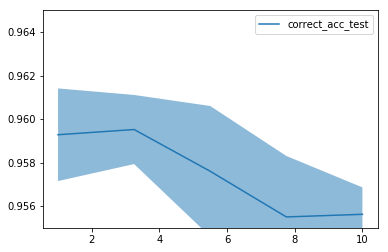

In [15]:
plt.figure()
plot_quantity(results_array, 'correct_acc_test')
plt.ylim(0.955, 0.965)
plt.legend()
plt.show()

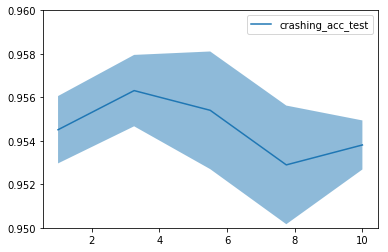

In [16]:
plt.figure()
plot_quantity(results_array, 'crashing_acc_test')
plt.ylim(0.95, 0.96)
plt.legend()
plt.show()